# A test for the risk-budgeting model

## Data/Stock choosing:
1. 2010-2022年中一直在上证300中的股票-52只
2. Monthly period from 2010 - 2022. 


In [205]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import test_result

In [206]:
data = pd.read_csv('./data/Monthly_Return_Rates.csv',index_col=0, parse_dates=True,infer_datetime_format = True)
data = data.fillna(0)
# 3. Construct risk budgeting portfolio
# portfolio dates
p_dates = data.index[data.index.year>=2017]
# initialise portfolio weights matrix
w = pd.DataFrame(index=p_dates, columns=data.columns)
# initialise portfolio return matrix
p_rets = pd.DataFrame(index=p_dates, columns=['return'])

In [211]:
index_df = pd.read_csv('./data/000300.csv')
index_df.index = p_dates

# Construct Portfolio

* objective function: min $\Sigma_{i=1}^N RC_i(w)$ (suppose N stocks)

$RC_i(W) = \frac{w_i(\Sigma w)_i}{(w^T\Sigma w)^{0.5}}$

* two constraint: no short sellings; full activate trader


* Following the logic from sta4020 asg7. Starting from the end of 2015, at the end of every month, use the historical asset returns (from 2011/1 to the end of that month).

想要有个整体函数可以选择我要的object func和constraint; 

cons_sum_weight()中的tw,cons_large_risk_constraint中的最大risk限制和small_risk_constraint中的最小risk限制也能直接调

In [219]:
"""
This file constructs a strategic ERP portfolio and compare with an equal weighted portfolio.
x: portfolio weights
p_cov: covariance matrix
"""

# risk budgeting approach optimisation object function
# minimize variance
def obj_fun(x, p_cov):
	return np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x)))**2)

# maximize mean
def obj_fun2(x,p_mean):
	return -np.sum(x*p_mean)

# maximize  mean-variance
def obj_fun3(x,p_mean,p_cov):
	return -np.sum(x*p_mean)+np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x)))**2)

# maximize sharp ratio
def obj_fun4(x,p_mean,p_cov):
	return -np.sum(x*p_mean)/(np.sum((x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))))**2)

# constraint on sum of weights equal to one
def cons_sum_weight(x,tw):
	return -np.sum(x)+tw

# constraint on weight larger than zero
def cons_long_only_weight(x):
	return x

# constraint about the marignal risk w.r.t. each stocks(upper bound)
def cons_large_risk_constraint(x,p_cov):
	return -x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))+0.05

# constraint about the marignal risk w.r.t. each stocks(lower bound)
def cons_small_risk_constraint(x,p_cov):
	return x*np.dot(p_cov, x)/np.dot(x.transpose(), np.dot(p_cov, x))-0.02

# calculate risk budgeting portfolio weight given risk budget
def rb_p_weights(asset_rets):
	# number of ARP series
	num_arp = asset_rets.shape[1]
	# covariance matrix of asset returns
	p_cov = asset_rets.cov()
	# mean of asset returns
	p_mean = asset_rets.mean()
	# initial weights
	w0 = 1.0 * np.ones((num_arp, 1)) / num_arp
	# constraints
	cons1 = {'type': 'ineq', 'fun': cons_sum_weight,'args':2}
	cons2 = {'type': 'ineq', 'fun': cons_long_only_weight}
	cons3 = {'type':'ineq','fun':cons_large_risk_constraint,'args':[p_cov]}
	cons4 = {'type':'ineq','fun':cons_small_risk_constraint,'args':[p_cov]}
	cons = (cons1,cons2)
	# portfolio optimisation
	return minimize(obj_fun3, w0, args=(p_mean,p_cov), constraints=cons)

# contruct portfolio
for t in p_dates:

	# re-balance the portfolio each month
	tmp_portfolio = data[data.index < t]
	tmp_portfolio = tmp_portfolio.iloc[1:,:]
	w.loc[t] = (rb_p_weights(tmp_portfolio).x)
	# calculate risk budgeting portfolio returns
	p_rets.loc[t] = np.sum(w.loc[t] * data.loc[t])

	

# 回测

In [218]:
test_result.calculate_result(p_rets)

,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,-0.742104,-0.204709,1.285943,-0.166967,-0.886148,0.464789,0.837449


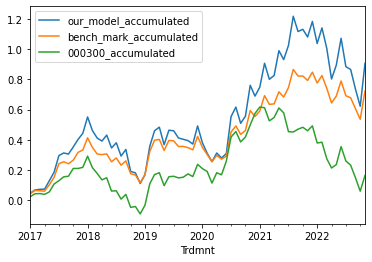

In [214]:
# 4. Construct equal weighted portfolio
ew_rets = pd.DataFrame(np.sum(1.0*data[data.index>=p_dates[0]]/data.shape[1], axis=1), columns=['return'])
# 5. Plot the portfolio cumulative returns
p_cumrets = ((p_rets['return'] + 1).cumprod()-1)
ew_cumrets = (ew_rets['return'] + 1).cumprod()-1
index_cumrets = (index_df['Idxrtn'] + 1).cumprod()-1
pd.concat([p_cumrets,ew_cumrets,index_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated','bench_mark_accumulated','000300_accumulated'])
plt.show()

* maximize the sharp ratio and the formula derivation: this repository may helps

https://github.com/PaiViji/PythonFinance--RiskBudgeted-Portfolio-Construction.git

* we can also use this repository to check the quality of our work:

https://github.com/jcrichard/pyrb.git